# <div style="text-align: center"> Goldman Sachs - Kozminski University Project

## Goal - Provide transparency of relationships between various EU regulations

## Scraping

### Importing packages

In [2]:
import bs4 as bs
import urllib.request as ur
import requests
import pandas as pd
import re
import numpy as np
from bs4 import BeautifulSoup
from time import sleep
import yake

### Tool to retrieve all regulation links from the website

This tool can be used for automatic extraction of all regulation links

In [4]:
domain = 'http://eur-lex.europa.eu/'
page_base_url = 'https://eur-lex.europa.eu/search.html?instInvStatus=ALL&qid=1407932788225&type=advanced&lang=en&SUBDOM_INIT=EU_CASE_LAW&FM_CODED=REG&page='
hook_text = './legal-content/EN/TXT/HTML/?'
html_link_re = re.compile(r'./legal-content/EN/TXT/HTML/[^"]*')

url_list = []
for i in range(1,10):
    response = requests.get(page_base_url + str(i))
    for path in  re.findall(html_link_re, response.text):
        sleep(1)
        continua = 1

        urls = domain + path[2:]
        url_list.append(urls)

KeyboardInterrupt: 

In [3]:
url_list

['http://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32021R0954&amp;rid=1',
 'http://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32021R0953&amp;rid=2',
 'http://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32021R0947&amp;rid=3',
 'http://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32021R0888&amp;rid=4',
 'http://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32021R0819&amp;rid=5',
 'http://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32021R0818&amp;rid=6',
 'http://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32021R0817&amp;rid=7',
 'http://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32021R0847&amp;rid=8',
 'http://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32021R0840&amp;rid=9',
 'http://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32021R0783&amp;rid=10',
 'http://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32021R0782&amp;rid=11',
 'http://eur-lex.europa.eu/legal-content/

### List of urls

In [5]:
urls = ['https://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32014L0065&from=EN', 
        'https://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32014R0596&from=EN',
       'https://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32017R0590&from=EN',
       'https://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32014R0600&from=EN',
       'https://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32014L0059&from=EN',
       'https://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32016R1712&from=EN',
       'https://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32012R0648&from=EN',
       'https://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32012R0648&from=EN',
       'https://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:32015R2365&from=EN']


Creating soup objects

In [6]:
all_=[]

for i in urls: 
    bs = BeautifulSoup(requests.get(i).text, 'html.parser')   
    all_.append(bs)

### Functions used for scraping

Extracting a regulation publish date

In [7]:
def get_publish_date(bs_obj):
    '''
    Gets publsh date of a given directive
    :param bs_obj:
    :return:
    '''
    return bs_obj.find('p', {'class': 'hd-date'}).get_text().strip()


Extracting a regulation title

In [8]:
def get_title(bs_obj):
    '''
    gets given directive's title
    :param bs_obj:
    :return:
    '''
    title = []
    title.append(bs_obj.find('p', {'class': 'doc-ti'}).get_text().strip())
    for line in bs_obj.findAll('p', {'class': ['doc-ti']}):
        if 'id' not in line.attrs:
            title.append(line.get_text().strip())
    return ' '.join(title)



Identifying articles tag

In [9]:
def get_articles(bs_obj):
    '''
    gets list of all articles
    :param bs_obj:
    :return:
    '''
    return bs.findAll('p', {'class': 'sti-art'})

Assigning text to articles

In [10]:
def assign_text_to_articles(articles: list):
    data = {}
    for index in range(len(articles)):
        article_text = []
        tag = articles[index].find_next_sibling()
        while True:
            if tag is None:
                break
            if tag in articles or tag.name == 'div':
                break
            article_text.append(tag)
            tag = tag.find_next_sibling()
        data[articles[index].text.strip()] = article_text
    return data

Extracting subparagraphs

In [11]:
def extract_subparagraphs(paragraph_tag):
    return [i.get_text().strip().replace('\xa0', ' ') for i in paragraph_tag.findAll('p', {'class': 'normal'})]

Extracting paragraphs

In [12]:
def extract_paragraphs(article_data: list):
    data = {}
    counter = 0
    for tag in article_data:
        if tag.name == 'p' and 'sti-art' in tag.attrs['class']:
            data['title'] = tag.get_text().strip()
            continue
        if tag.name == 'p' and 'normal' in tag.attrs['class']:
            counter += 1
            data[counter] = []
            data[counter].append(tag.get_text().strip().replace('\xa0', ' '))
            continue
        sub_par = extract_subparagraphs(tag)
        data[counter].append(sub_par)
    return data

Extracting regulation text, unstructured

In [13]:
def get_text(bs_obj):
    new =[]
    print(type(bs_obj))
    for x in bs_obj.findAll('p',  {"class": ['normal']}):
        new.append(x.get_text().strip().replace('\xa0', ' '))
    return ' '.join(new)


Extracting articles titles

In [14]:
def get_article_title(bs_obj):
    '''
    gets given directive's title
    :param bs_obj:
    :return:
    '''
    article_title =[]
    article_text = []
    
    for index in bs.findAll('p',  {"class": 'sti-art'}):
        article_title.append(index.get_text().strip())
    return ', '.join(article_title)


### Extracting

Extracting everything for all provided regulations

In [15]:
titles=[]
publ_dates=[]
texts = []
articles_html=[]
articles_texts=[]
articles_titles=[]
topic =[]

for bs in all_: 
    #Extracting all regulation titles
    title = get_title(bs)
    titles.append(title)
    
    #Extracting all regulation publish dates
    publ_date = get_publish_date(bs)
    publ_dates.append(publ_date)
    
    #Extracting all text, unstructured
    all_text = get_text(bs)
    texts.append(all_text)
    
    #Extracting all articles html
    articles = get_articles(bs)
    article_html = assign_text_to_articles(articles)
    articles_html.append(article_html)
    
    #Extracting articles structured text - suitable eg. for database
    result = {article: extract_paragraphs(content) for article, content in article_html.items()}
    articles_texts.append(result)
    
    #Extracting article title
    article_title = get_article_title(bs)
    articles_titles.append(article_title)
    

<class 'bs4.BeautifulSoup'>
<class 'bs4.BeautifulSoup'>
<class 'bs4.BeautifulSoup'>
<class 'bs4.BeautifulSoup'>
<class 'bs4.BeautifulSoup'>
<class 'bs4.BeautifulSoup'>
<class 'bs4.BeautifulSoup'>
<class 'bs4.BeautifulSoup'>
<class 'bs4.BeautifulSoup'>


## Summary Table

Creating Summary table after web scraping

In [16]:
d = {'Title':titles,'Publish Date':publ_dates, 'Articles titles': articles_titles, 'All text':texts}
df_summary = pd.DataFrame(d)
pd.set_option('display.max_colwidth', 300)
df_summary = df_summary.set_index('Title',append=True)
df_summary = df_summary.set_index('Publish Date',append=True)
df_summary

,,,Articles titles,All text
,Title,Publish Date,,
0,DIRECTIVE 2014/65/EU OF THE EUROPEAN PARLIAMENT AND OF THE COUNCIL of 15 May 2014 on markets in financial instruments and amending Directive 2002/92/EC and Directive 2011/61/EU (recast) (Text with EEA relevance),12.6.2014,"Scope, Exemptions, Optional exemptions, Definitions, Requirement for authorisation, Scope of authorisation, Procedures for granting and refusing requests for authorisation, Withdrawal of authorisations, Management body, Shareholders and members with qualifying holdings, Notification of proposed ...","THE EUROPEAN PARLIAMENT AND THE COUNCIL OF THE EUROPEAN UNION, Having regard to the Treaty on the Functioning of the European Union, and in particular Article 53(1) thereof, Having regard to the proposal from the European Commission, After transmission of the draft legislative act to the nationa..."
1,"REGULATION (EU) No 596/2014 OF THE EUROPEAN PARLIAMENT AND OF THE COUNCIL of 16 April 2014 on market abuse (market abuse regulation) and repealing Directive 2003/6/EC of the European Parliament and of the Council and Commission Directives 2003/124/EC, 2003/125/EC and 2004/72/EC (Text with EEA relevance)",12.6.2014,"Subject matter, Scope, Definitions, Notifications and list of financial instruments, Exemption for buy-back programmes and stabilisation, Exemption for monetary and public debt management activities and climate policy activities, Inside information, Insider dealing, Legitimate behaviour, Unlawfu...","THE EUROPEAN PARLIAMENT AND THE COUNCIL OF THE EUROPEAN UNION, Having regard to the Treaty on the Functioning of the European Union, and in particular Article 114 thereof, Having regard to the proposal from the European Commission, After transmission of the draft legislative act to the national ..."
2,COMMISSION DELEGATED REGULATION (EU) 2017/590 of 28 July 2016 supplementing Regulation (EU) No 600/2014 of the European Parliament and of the Council with regard to regulatory technical standards for the reporting of transactions to competent authorities (Text with EEA relevance),31.3.2017,"Data standards and formats for transaction reporting, Meaning of transaction, Meaning of execution of a transaction, Transmission of an order, Identification of the investment firm executing a transaction, Designation to identify natural persons, Details of the identity of the client and identif...","THE EUROPEAN COMMISSION, Having regard to the Treaty on the Functioning of the European Union, Having regard to Regulation (EU) No 600/2014 of the European Parliament and of the Council of 15 May 2014 on markets in financial instruments and amending Regulation (EU) No 648/2012 (1), and in partic..."
3,REGULATION (EU) No 600/2014 OF THE EUROPEAN PARLIAMENT AND OF THE COUNCIL of 15 May 2014 on markets in financial instruments and amending Regulation (EU) No 648/2012 (Text with EEA relevance),12.6.2014,"Subject matter and scope, Definitions, Pre-trade transparency requirements for trading venues in respect of shares, depositary receipts, ETFs, certificates and other similar financial instruments, Waivers for equity instruments, Volume Cap Mechanism, Post-trade transparency requirements for trad...","THE EUROPEAN PARLIAMENT AND THE COUNCIL OF THE EUROPEAN UNION, Having regard to the Treaty on the Functioning of the European Union, and in particular Article 114 thereof, Having regard to the proposal from the European Commission, After transmission of the draft legislative act to the national ..."
4,"DIRECTIVE 2014/59/EU OF THE EUROPEAN PARLIAMENT AND OF THE COUNCIL of 15 May 2014 establishing a framework for the recovery and resolution of credit institutions and investment firms and amending Council Directive 82/891/EEC, and Directives 2001/24/EC, 2002/47/EC, 2004/25/EC, 2005/56/EC, 2007/36/EC, 2011/35/EU, 2012/30/EU and 2013/36/EU, and Regulations (EU) No 1093/2010 and (EU) No 648/2012, of the European Parliament and of the Council (Text with EEA relevance)",12.6.2014,"Subject mat

Print articles_html or articles_texts to see the structure

In [17]:
# print(articles_html)
# print(articles_texts)

## Text analysis

Extracting key phrases

In [18]:
texts = ''.join(texts)

In [19]:
#texts

In [20]:
text_analysis = re.compile(r"(article|articles|european|union|parliament|information|market|paragraph|inside|order|annex|v.part|member|competent|accordance|regulary|directive|)")
text = texts.lower()
final_text = re.sub(text_analysis, '',text)

In [21]:
kw_extractor = yake.KeywordExtractor()
keywords = kw_extractor.extract_keywords(final_text)

language = "en"
max_ngram_size = 3
deduplication_thresold = 0.9
deduplication_algo = 'seqm'
windowSize = 1
numOfKeywords = 30

custom_kw_extractor = yake.KeywordExtractor(lan=language, n = max_ngram_size, dedupLim=deduplication_thresold, dedupFunc=deduplication_algo, windowsSize=windowSize, top=numOfKeywords, features=None)
keywords = custom_kw_extractor.extract_keywords(final_text)

for kw in keywords:
    list_kw = kw[0]
    print(list_kw)

financial instruments
resolution authorities
resolution authority
regulatory technical standards
investment firm
technical standards referred
resolution
financial
authorities
authority
referred
regulation
esma
technical standards
investment
states
draft regulatory technical
institution
trading
state
regulatory technical
trading venue
ccp
instruments
standards referred
ensure
commission
firm
group-level resolution authority
investment services


Creating a graphics of most important words

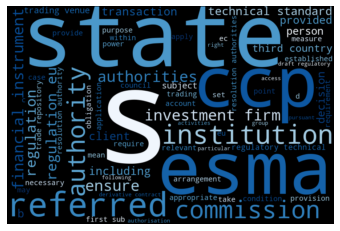

In [22]:
# Libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a list of word
text=(final_text)

# Create the wordcloud object
wordcloud = WordCloud(width=900, height=600, max_words=70, colormap="Blues").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

## Definitions

#### Creating table of definitions

Creating a data frame from articles_html to extract Definitions, joining lists

In [23]:
df_html = pd.DataFrame(articles_html)

In [24]:
definit_html = df_html['Definitions'].dropna()

In [25]:
definit_html = definit_html.tolist()

In [26]:
for elem in definit_html:
    del elem[0]      

In [27]:
definit_html = sum(definit_html, [])

Extracting text using get_text funcion shown earlier

In [28]:
def_texts = []

for tag in definit_html:
    text = get_text(tag)
    def_texts.append(text)

<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.element.Tag'>
<class 'bs4.

Creating a table of definitions, with html, suitable for Machine Learning

In [29]:
titles_2 = {'Html': definit_html, 'Definition': def_texts}
table_of_definitions_2 = pd.DataFrame(titles_2)

In [30]:
table_of_definitions_2 = table_of_definitions_2[table_of_definitions_2['Definition'].map(lambda d: len(d)) > 0].reset_index(drop=True)

In [31]:
table_of_definitions_2
table_of_definitions_2['Names'] = table_of_definitions_2.Definition.str.split('’ ', expand = True)[0]
table_of_definitions_2['Definitions'] = table_of_definitions_2.Definition.str.split('’ ', expand = True)[1]


In [32]:
table_of_definitions_2.drop('Definition', axis='columns', inplace=True)

In [33]:
table_of_definitions_2['Name'] = table_of_definitions_2.Names.str.split('‘', expand = True)[1]

In [34]:
table_of_definitions_2.drop('Names', axis='columns', inplace=True)

In [35]:
table_of_definitions_2.head(5)

,Html,Definitions,Name
0,"[\n, [], \n, [], \n, [\n, [\n, <td valign=""top"">\n<p class=""normal"">(1)</p>\n</td>, \n, <td valign=""top"">\n<p class=""normal"">‘investment firm’ means any legal person whose regular occupation or business is the provision of one or more investment services to third parties and/or the performance o...",means any legal person whose regular occupation or business is the provision of one or more investment services to third parties and/or the performance of one or more investment activities on a professional basis. Member States may include in the definition of investment firms undertakings which...,investment firm
1,"[\n, [], \n, [], \n, [\n, [\n, <td valign=""top"">\n<p class=""normal"">(2)</p>\n</td>, \n, <td valign=""top"">\n<p class=""normal"">‘investment services and activities’ means any of the services and activities listed in Section A of Annex I relating to any of the instruments listed in Section C of Anne...",means any of the services and activities listed in Section A of Annex I relating to any of the instruments listed in Section C of Annex I. The Commission shall adopt delegated acts in accordance with Article 89 measures specifying: (a) the derivative contracts referred to in Section C.6 of Annex...,investment services and activities
2,"[\n, [], \n, [], \n, [\n, [\n, <td valign=""top"">\n<p class=""normal"">(3)</p>\n</td>, \n, <td valign=""top"">\n<p class=""normal"">‘ancillary services’ means any of the services listed in Section B of Annex I;</p>\n</td>, \n], \n], \n]",means any of the services listed in Section B of Annex I;,ancillary services
3,"[\n, [], \n, [], \n, [\n, [\n, <td valign=""top"">\n<p class=""normal"">(4)</p>\n</td>, \n, <td valign=""top"">\n<p class=""normal"">‘investment advice’ means the provision of personal recommendations to a client, either upon its request or at the initiative of the investment firm, in respect of one or ...","means the provision of personal recommendations to a client, either upon its request or at the initiative of the investment firm, in respect of one or more transactions relating to financial instruments;",investment advice
4,"[\n, [], \n, [], \n, [\n, [\n, <td valign=""top"">\n<p class=""normal"">(5)</p>\n</td>, \n, <td valign=""top"">\n<p class=""normal"">‘execution of orders on behalf of clients’ means acting to conclude agreements to buy or sell one or more financial instruments on behalf of clients and includes the concl...",means acting to conclude agreements to buy or sell one or more financial instruments on behalf of clients and includes the conclusion of agreements to sell financial instruments issued by an investment firm or a credit institution at the moment of their issuance;,execution of orders on behalf of clients


Saving tables of definitions as an Excel files

In [36]:
import openpyxl

In [39]:
table_of_definitions_2.to_excel(r'/Users/Marta/Desktop/Definitions_ML.xlsx', index = False)